# Arbol de Decisión

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [3]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo
import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [4]:
df = generate_initial_dataset(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [5]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


In [6]:
df.shape

(801, 15)

# Entrenamiento

In [7]:
# X, y = df.iloc[:,:-1], df.iloc[:,-1]
X = df.loc[:,['tipo_de_sala_0', 'tipo_de_sala_1', 'tipo_de_sala_2', 'id_usuario', 'genero_0', 'genero_1', 'edad',
              'amigos',	'parientes', 'precio_ticket', 'nombre_sede_0', 'nombre_sede_1', 'nombre_sede_2', 
              'cant_acompañantes']]
y = df.loc[:,'volveria']

In [8]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [9]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [11]:
max_depths = np.arange(1, 25)
min_samples_leafs = np.arange(1, 51)
data_points = []
for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        clf = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
        )
        clf.fit(X_train, y_train)
        data_points.append(
            (max_depth, min_samples_leaf, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]),)
        )

data_points = pd.DataFrame(
    data_points, columns=["max_depth", "min_samples_leaf", "score"]
)

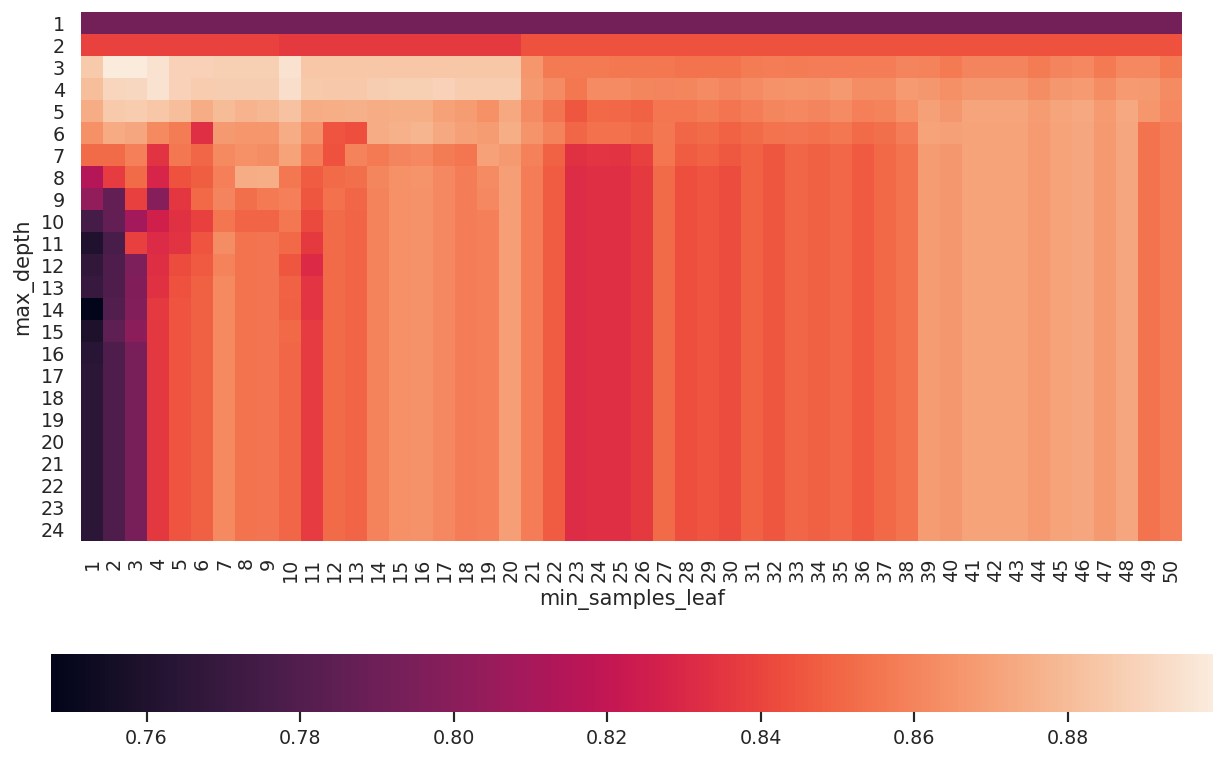

In [12]:
plt.figure(dpi=125, figsize=(12, 8))
g = sns.heatmap(
    data_points.pivot_table(
        index="max_depth", columns="min_samples_leaf", values="score"
    ),
    square=True,
    cbar_kws=dict(use_gridspec=False, location="bottom"),
)

# Baseline

Entrenamos el modelo considerando parámetros que nos parecen razonables, en base al plot

In [13]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=117)

### Stratified K Fold

In [14]:
kf = StratifiedKFold(n_splits=5)

max_depth = 3
min_samples_leaf = 10

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    arbol = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
    )
    arbol.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], arbol.predict(X.iloc[test_index]))
    print(f"Fold {fold_idx}: AUC ROC score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"Mean test AUC ROC is: {np.mean(test_rocs):.4f}")

Fold 0: AUC ROC score is 0.7801
Fold 1: AUC ROC score is 0.7994
Fold 2: AUC ROC score is 0.8637
Fold 3: AUC ROC score is 0.7856
Fold 4: AUC ROC score is 0.7796
Mean test AUC ROC is: 0.8017


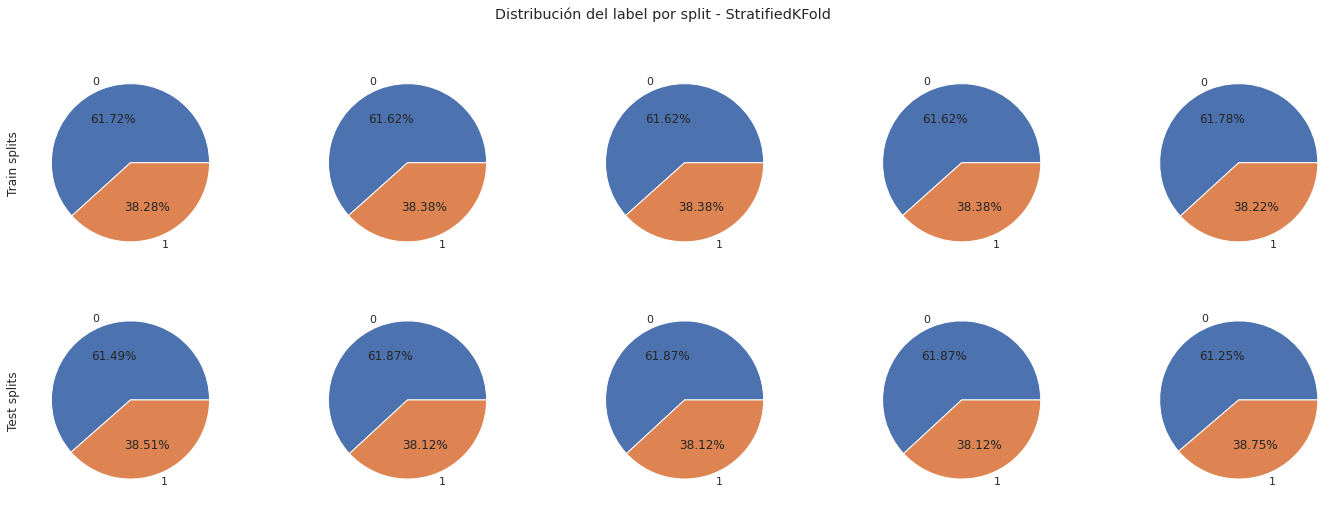

In [15]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 8), sharey=True)

kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    pd.Series(y[train_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[0][fold_idx]
    )
    pd.Series(y[test_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[1][fold_idx]
    )

axes[0][0].set_ylabel("Train splits")
axes[1][0].set_ylabel("Test splits")
plt.suptitle("Distribución del label por split - StratifiedKFold")

plt.show()

# Métricas

### AUC ROC

In [16]:
roc = roc_auc_score(y_test, arbol.predict_proba(X_test)[:,1])
print(f"{roc:.4f}")

0.8906


### Accuracy

In [17]:
acc = accuracy_score(y_test, arbol.predict(X_test))
print(f"{acc:.4f}")

0.8557


### Precision

In [18]:
precision = precision_score(y_test, arbol.predict(X_test))
print(f"{precision:.4f}")

0.8261


### Recall

In [19]:
recall = recall_score(y_test, arbol.predict(X_test), pos_label=0)
print(f"{recall:.4f}")

0.9055


### F1-Score

In [20]:
f1 = f1_score(y_test, arbol.predict(X_test))
print(f"{f1:.4f}")

0.7972


### Matriz de confusión

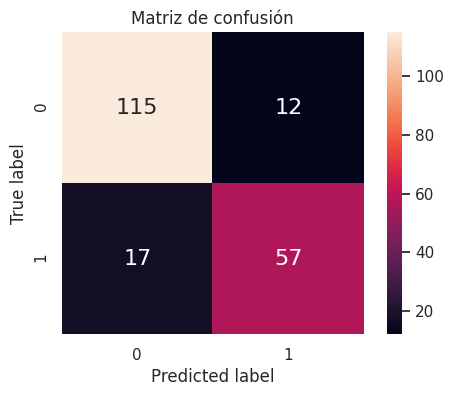

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusión")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, arbol.predict(X_test))

## Viendo el modelo

Dado que obtuvimos un 86% de accuracy y un 81% con Stratified K fold, no está demás imprimir el arbol para ver cómo decide

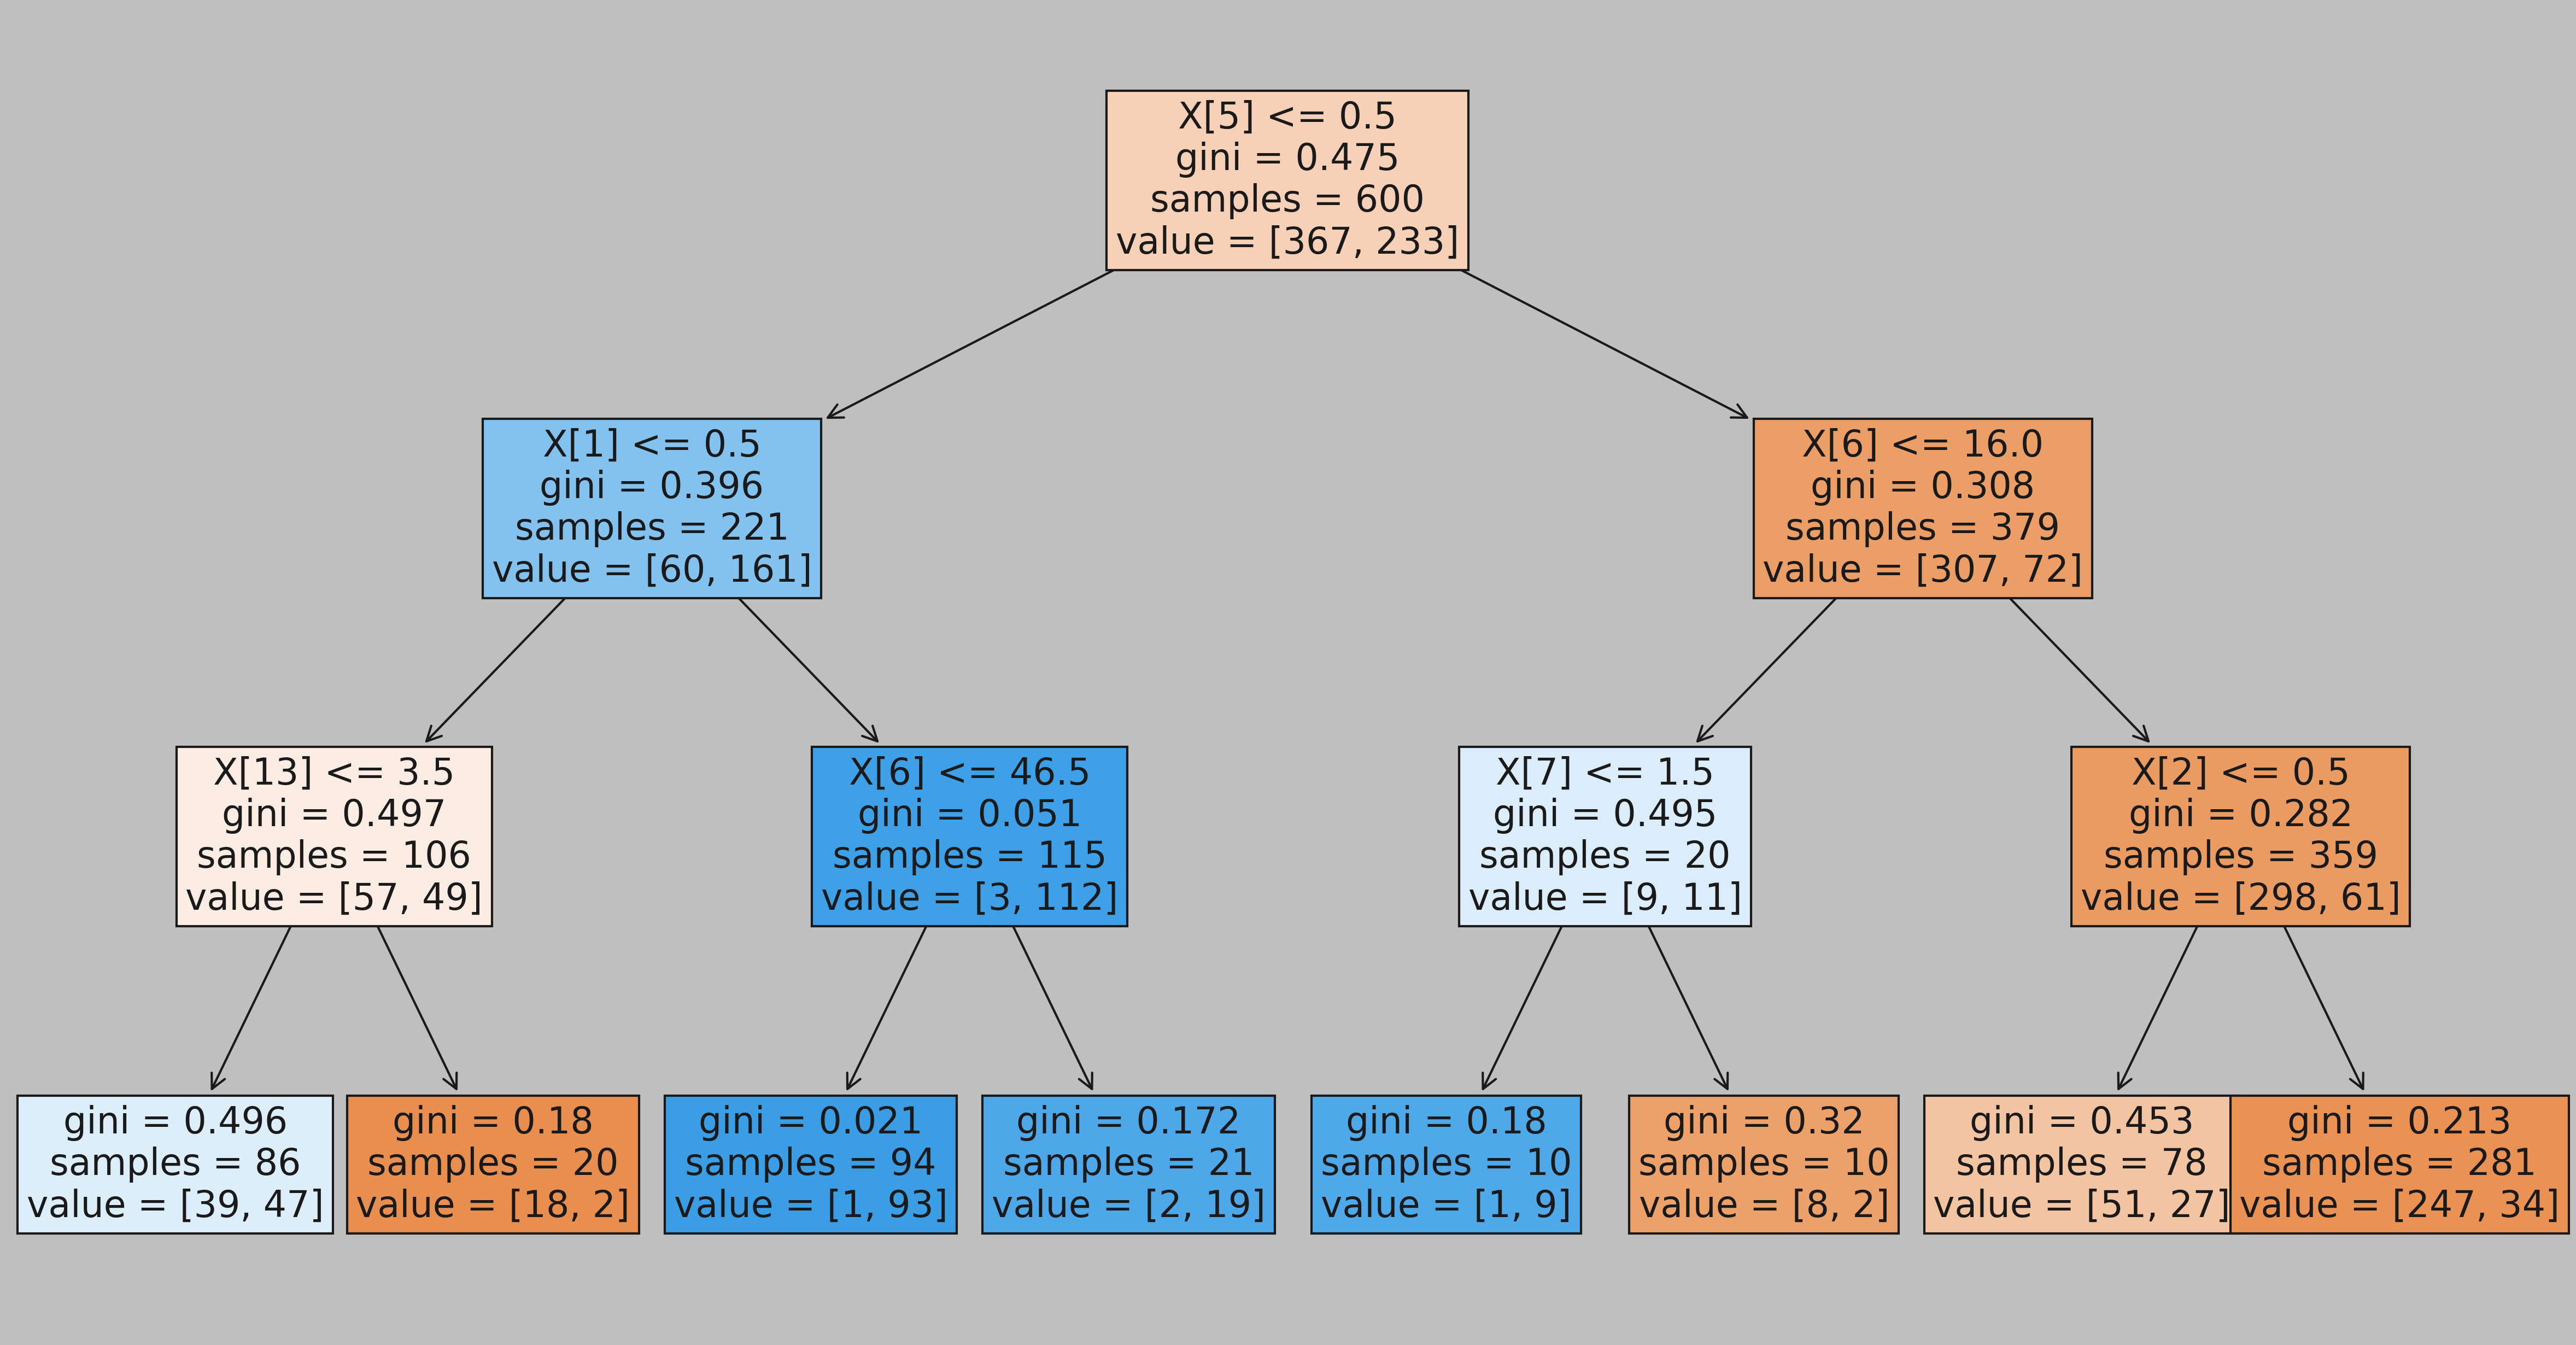

In [22]:
with plt.style.context("classic"):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=300)
    plot_tree(clf, filled=True, fontsize=16)

# Test Holdout

Por último, para validar contra datos nunca vistos, usamos un conjunto de holdout.

En este caso, y para todos los modelos de este TP, es un nuevo archivo para el que no poseemos los valores a predecir

In [23]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [24]:
holdout.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


In [25]:
holdout.shape

(90, 11)

In [26]:
df_h = generate_holdout_dataset(holdout)
df_h = replace_nulls_edad(df_h, 'media')
df_h = encodear_atributos_categoricos(df_h)
df_h = df_h.drop(['volveria'], axis=1)

In [27]:
df_h.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,650,0,1,26.0,0,0,1,0,0,1,0
1,0,0,1,234,0,1,8.0,4,2,4,0,0,1,6
2,0,1,0,31,1,0,43.0,0,0,3,0,1,0,0
3,0,1,1,552,1,0,30.0,0,0,3,0,0,1,0
4,0,0,1,411,1,0,32.8,0,0,1,0,0,1,0


In [28]:
y_pred = clf.predict(df_h)

In [29]:
y_pred

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1])

In [30]:
(y_pred.shape, df_h.shape)

((90,), (90, 14))

In [31]:
serie_predicha = pd.Series(y_pred, name='volveria') 
serie_predicha = serie_predicha.to_frame()
serie_predicha.head(15)

,volveria
0,0
1,0
2,1
3,1
4,1
5,0
6,0
7,1
8,1
9,0


In [32]:
df_predicho = holdout.join(serie_predicha, how='inner')
df_predicho.head(7)

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede,volveria
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo,0
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo,0
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita,1
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo,1
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo,1
5,3d,Señora Elsa Maria Dominga,134,mujer,32.0,1,0,44:636,3,NaN,fiumark_palermo,0
6,normal,Señorita Adelina Paz,497,mujer,57.0,1,0,58;69,8,adelante,fiumark_chacarita,0


In [33]:
cols = ['id_usuario', 'volveria']
df_resultado = df_predicho[cols]
df_resultado.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,1
4,411,1


In [34]:
df_resultado.shape

(90, 2)

In [35]:
df_resultado.to_csv('prediccion/arbol_resultado_final.csv')